<h3 style="color:deepskyblue">The Particle Method for Smile Calibration</h3>

Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,S) \equiv 15\%$.

Below we describe a Monte Carlo simulation scheme for the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{-\kappa\left(t_i-s\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{Var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simulate the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\quad\text{or}\quad
\text{Corr}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3). That is,

\begin{align}
\log S_{t_i} &= \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1-\bar{\rho}^2}Z_1+\bar{\rho}Z_2\right),\quad\text{where }\bar{\rho}=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}\\
Y_{t_i} &= e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\gamma\sqrt{\frac{1-e^{-2\kappa\Delta t_i}}{2\kappa}}Z_2
\end{align}
where $Z_1$ and $Z_2$ are independent standard normal variables.

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid $G_{t_k}$ of spot values) involves the ratio of two sums of $N$ terms each. For the minimum and maximum values of $G_{t_k}$, take the 0.1% and 99.9% quantiles of the risk-neutral distribution of $S$ at $t_k$, i.e., since the smile is flat at $\sigma_{\textrm{Market}}$, of the distribution of $S_0\exp(\sigma_{\textrm{Market}}\sqrt{t_k}G - \frac12 \sigma_{\textrm{Market}}^2 t_k)$, with $G$ a standard Gaussian random variable. 

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
T = 1; S0 = 100; sigma0 = sigma_market = sigma_Dup = 0.15; Y0 = 0; rho = -0.5; gamma = 0.5; kappa = 1; dt = 0.01
N = 10000; N2 = 100000; n = int(T/dt) # n-steps, N-simulations, N2-pricing simulations
strike_array = np.arange(70,150,10)

rho_bar = rho*np.sqrt(2*(1-np.exp(-kappa*dt))/(kappa*dt*(1+np.exp(-kappa*dt))))


tt = np.linspace(0, T, n)
max_015_tt = np.linspace(0, T, n)
max_015_tt[max_015_tt < 0.15] = 0.15

h = kappa * sigma_market * S0 * np.sqrt(max_015_tt) * N**(-0.2)

In [4]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [5]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.20654803)

In [6]:
def covar(k_1, k_2, rho, t):
    return rho*(1-np.exp(-(k_1+k_2)*t))/(k_1+k_2)

In [7]:
def quartic_kernel(x):
    x = np.clip(x, -1, 1)
    return (x+1)**2*(1-x)**2

In [8]:
def calibrate(S0, rho_bar, kappa, gamma, dt, sigma0, sigma_Dup, h, n):
    "Simulating Yt, a_t, logSt, and eventually get l(t, St)"
    # np.random.seed(999)
    l_dist = np.ones((100,))
    St_dist = np.linspace(70, 150, 100)

    Y = np.zeros((n+1, N))
    a = np.zeros((n+1, N))
    logS = np.zeros((n+1,N))
    logS[0] = np.log(S0)


    for i in range(n):
        z1, z2 = np.random.normal(size=(2, N))
        z1 = np.sqrt(1-rho_bar**2)*z1 + rho_bar*z2
        Y[i+1] = Y[i]*np.exp(-kappa*dt) + gamma * np.sqrt(covar(kappa,kappa,1,dt))*z2
        a[i+1] = sigma0 * np.exp(Y[i+1])
        # use interpolation to locate l(t, St)
        l_t_St = np.interp(np.exp(logS[i]), St_dist, l_dist)
        logS[i+1] = logS[i] - 0.5*(a[i]*l_t_St)**2*dt + a[i]*l_t_St*np.sqrt(dt)*z1

        # update St and l(t, St) using particle algorithm
        q001, q999 = np.quantile(logS[i+1], [0.001, 0.999])
        q001 = min(np.exp(q001), S0-1)
        q999 = max(np.exp(q999), S0+1)
        St_dist = np.linspace(q001, q999, 100)

        E_a2 = np.zeros(St_dist.shape)

        for j in range(100):
            St_j = St_dist[j]
            delta = quartic_kernel((np.exp(logS[i+1]) - St_j)/h[i]) * h[i]
            E_a2[j] = np.sum(a[i+1]**2 * delta) / np.sum(delta) if np.sum(delta) > 0 else 0
            l_dist[j] = sigma_Dup / np.sqrt(E_a2[j]) if E_a2[j] > 0 else 0
    return St_dist, l_dist

St_dist, l_dist = calibrate(S0, rho_bar, kappa, gamma, dt, sigma0, sigma_Dup, h, n)

Text(0.5, 1.0, 'Calibrated l(t, St)')

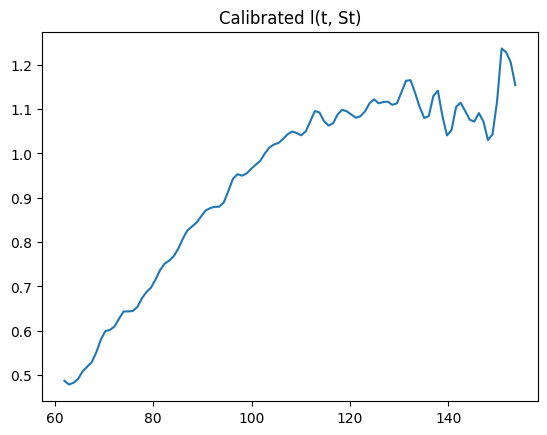

In [9]:
plt.plot(St_dist, l_dist)
plt.title("Calibrated l(t, St)")

Text(0.5, 1.0, 'BS volatility')

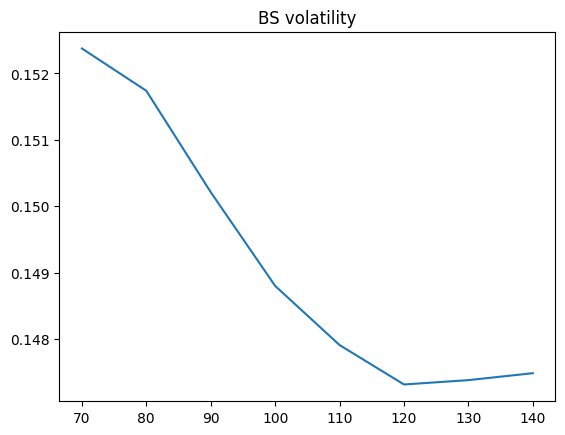

In [10]:
def verify_calibration(S0, rho_bar, kappa, gamma, dt, St_dist, l_dist, strike_array, N2):
    "Verify calibrated by simulating option prices"
    # np.random.seed(999)

    Y = np.zeros((n+1, N2))
    a = np.zeros((n+1, N2))
    logS = np.zeros((n+1,N2))
    logS[0] = np.log(S0)


    for i in range(100):
        z1, z2 = np.random.normal(size=(2, N2))
        z1 = np.sqrt(1-rho_bar**2)*z1 + rho_bar*z2
        Y[i+1] = Y[i]*np.exp(-kappa*dt) + gamma * np.sqrt(covar(kappa,kappa,1,dt))*z2
        a[i+1] = sigma0 * np.exp(Y[i+1])
        # use interpolation to locate l(t, St)
        l_t_St = np.interp(np.exp(logS[i]), St_dist, l_dist)
        logS[i+1] = logS[i] - 0.5*(a[i]*l_t_St)**2*dt + a[i]*l_t_St*np.sqrt(dt)*z1

    opt_price = np.average(np.maximum(np.exp(logS[-1])-strike_array.reshape(-1,1),0),axis=1)
    sigma_BS = blackscholes_impv(strike_array, T, S0, opt_price, callput='call')
    return sigma_BS

sigma_BS = verify_calibration(S0, rho_bar, kappa, gamma, dt, St_dist, l_dist, strike_array, N2)
plt.plot(strike_array, sigma_BS)
plt.title('BS volatility')

The Black-scholes volatility is around 15%, which means the SLV model is calibrated to the market volatility.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

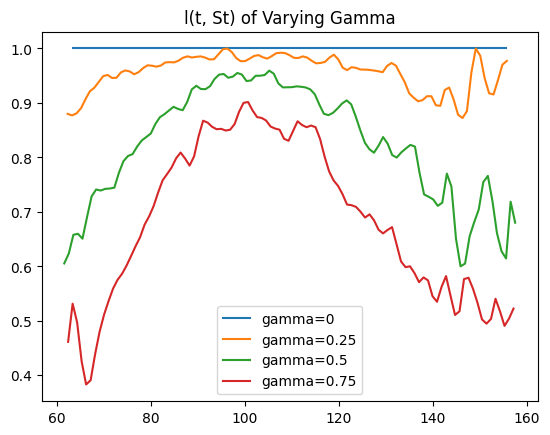

In [18]:
rho_new = 0
gamma_array = [0, 0.25, 0.5, 0.75]

l_dist_gamma = np.zeros((len(gamma_array), 100))
St_dist_gamma = np.zeros((len(gamma_array), 100))

for i, gamma_new in enumerate(gamma_array):
    St_dist_gamma[i], l_dist_gamma[i] = calibrate(S0, rho_new, kappa, gamma_new, dt, sigma0, sigma_Dup, h, n)
    plt.plot(St_dist_gamma[i], l_dist_gamma[i])

plt.title("l(t, St) of Varying Gamma")
plt.legend([f'gamma={_}' for _ in gamma_array])

When $\gamma = 0$, the corresponding calibrated $l(t, S_t) \equiv 1$. As $\gamma$ gets larger, the $l(t, S_t)$ becomes a $\cap$ shape and lower in value.

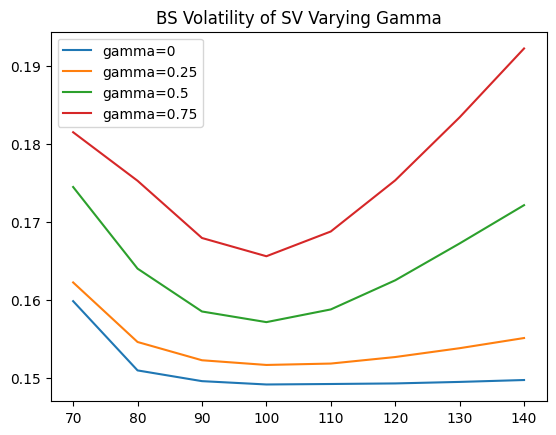

In [12]:
# BS volatility for SV model with different gamma
sigma_BS_gamma = np.zeros((len(gamma_array), len(strike_array)))
for i, gamma_new in enumerate(gamma_array):
    sigma_BS_gamma[i] = verify_calibration(S0, rho_new, kappa, gamma_new, dt, St_dist_gamma[i], l_dist_gamma[0], strike_array, N2)

plt.plot(strike_array, sigma_BS_gamma.T)
plt.title("BS Volatility of SV Varying Gamma")
plt.legend([f'gamma={_}' for _ in gamma_array])

When $\gamma$ gets higher, BS volatility becomes higher and the smile becomes steeper at low and high moneyness.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.


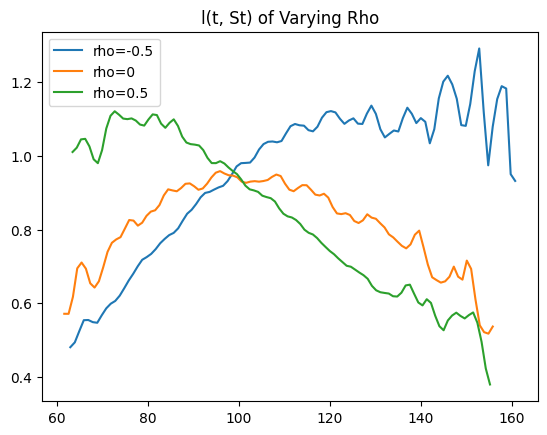

In [13]:
gamma_new = 0.5
rho_array = [-0.5, 0, 0.5]
rho_bar_array = np.array(rho_array)*np.sqrt(2*(1-np.exp(-kappa*dt))/(kappa*dt*(1+np.exp(-kappa*dt))))

l_dist_rho = np.zeros((len(gamma_array), 100))
St_dist_rho = np.zeros((len(gamma_array), 100))

for i, rho_bar_new in enumerate(rho_bar_array):
    St_dist_rho[i], l_dist_rho[i] = calibrate(S0, rho_bar_new, kappa, gamma_new, dt, sigma0, sigma_Dup, h, n)
    plt.plot(St_dist_rho[i], l_dist_rho[i])

plt.title("l(t, St) of Varying Rho")
plt.legend([f'rho={_}' for _ in rho_array])

The $l(t, S_t)$ is generally $\cap$ shaped. When $\rho<0$, it tilts to the right, generally upward sloping; when $\rho>0$, it tilts to the left, generally downward sloping.

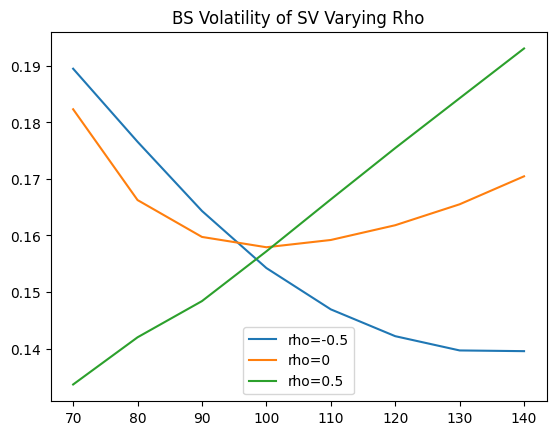

In [14]:
# BS volatility for SV model with different rho
sigma_BS_rho = np.zeros((len(rho_array), len(strike_array)))
for i, rho_bar_new in enumerate(rho_bar_array):
    sigma_BS_rho[i] = verify_calibration(S0, rho_bar_new, kappa, gamma_new, dt, St_dist_rho[i], l_dist_gamma[0], strike_array, N2)

plt.plot(strike_array, sigma_BS_rho.T)
plt.title("BS Volatility of SV Varying Rho")
plt.legend([f'rho={_}' for _ in rho_array])

When $\rho=0$, BS volatility smile is U shaped. When $\rho<0$, it becomes downward sloping; when $\rho>0$, it becomes upward sloping.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

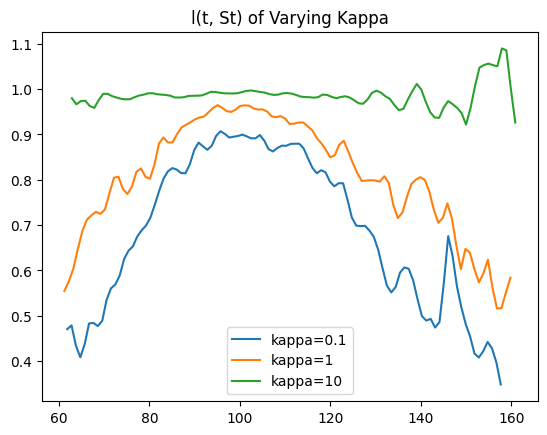

In [15]:
rho_new = 0; gamma_new = 0.5
kappa_array = [0.1, 1, 10]

l_dist_kappa = np.zeros((len(kappa_array), 100))
St_dist_kappa = np.zeros((len(kappa_array), 100))

for i, kappa_new in enumerate(kappa_array):
    St_dist_kappa[i], l_dist_kappa[i] = calibrate(S0, rho_new, kappa_new, gamma_new, dt, sigma0, sigma_Dup, h, n)
    plt.plot(St_dist_kappa[i], l_dist_kappa[i])

plt.title("l(t, St) of Varying Kappa")
plt.legend([f'kappa={_}' for _ in kappa_array])

When $\kappa$ is high, the $l(t, St)$ approaches a constant 1. As $\kappa$ gets smaller, the $l(t, S_t)$ becomes $\cap$ shaped and lower in value.

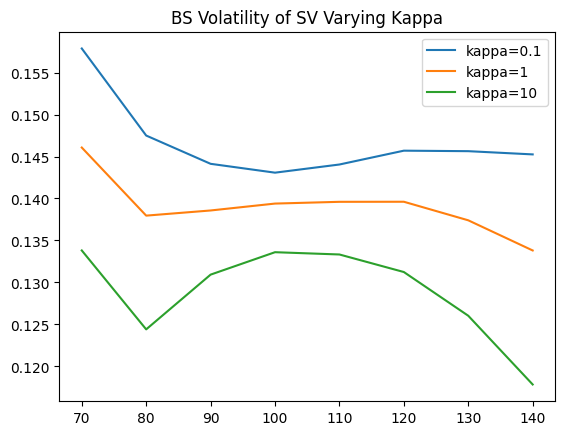

In [17]:
# BS volatility for SV model with different kappa
sigma_BS_kappa = np.zeros((len(kappa_array), len(strike_array)))
for i, kappa_new in enumerate(kappa_array):
    sigma_BS_kappa[i] = verify_calibration(S0, rho_new, kappa_new, gamma_new, dt, St_dist_kappa[i], l_dist_kappa[0], strike_array, N2)

plt.plot(strike_array, sigma_BS_kappa.T)
plt.title("BS Volatility of SV Varying Kappa")
plt.legend([f'kappa={_}' for _ in kappa_array])

As $\kappa$ gets smaller, the BS volatiltity becomes lower in value. Note that the estimation at very low(70) and very high(140) might be inaccurate because too few points lie in these ranges. 


<b>(e).</b> Consider the forward-starting straddle with payoff
\begin{equation*}
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In Black-Scholes model, the $S_t$ follows a geometric Brownian motion,

$$
\frac{dS_t}{S_t} = (r-q)dt + \sigma dW_t \\
S_{T_2} = S_{T_1}e^{(r-q-\frac{1}{2}\sigma^2)(T_2-T_1) + \sigma (W_{T_2}-W_{T_1})} \\
\frac{S_{T_2}}{S_{T_1}} = e^{(r-q-\frac{1}{2}\sigma^2)(T_2-T_1) + \sigma (W_{T_2 - T_1})} \\
$$

Let $X_t = \frac{S_{T_1+t}}{S_{T_1}}$, $X_t$ also follows a geometric Brownian motion,
$$
d X_t = X_t ((r-q)dt + \sigma dW_t)
$$

The straddle payoff can be writen into the sum of a call and a put,
$$
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert = (\frac{S_{T_2}}{S_{T_1}}-1)^+ + (1-\frac{S_{T_2}}{S_{T_1}})^+\\
= (X_{T_2-T_1}-1)^+ + (1-X_{T_2-T_1})^+
$$ 
which can be computed using Black-Scholes formula, with $S_0 = 1, K = 1, T=T_2-T_1$.

In [20]:
T1 = T-3/12; T2 = T
gamma_new = 1; rho_new = -0.5
rho_bar_new = rho_new*np.sqrt(2*(1-np.exp(-kappa*dt))/(kappa*dt*(1+np.exp(-kappa*dt))))
Price_BS = blackscholes_price(1, T2-T1, 1, sigma_market, callput='call') + blackscholes_price(1, T2-T1, 1, sigma_market, callput='put')
print("Straddle option price under Black Scholes model:", Price_BS)

Straddle option price under Black Scholes model: 0.05982731970363908


In [26]:
# Pricing straddle option
def pricing_SLV(S0, rho_bar, kappa, gamma, dt, St_dist, l_dist, T1, T2, N2):
    "Pricing options by simulating paths under SLV"
    # np.random.seed(999)
    n1 = int(T1/dt)
    n2 = int(T2/dt)

    Y = np.zeros((n2+1, N2))
    a = np.zeros((n2+1, N2))
    logS = np.zeros((n2+1,N2))
    logS[0] = np.log(S0)


    for i in range(n2):
        z1, z2 = np.random.normal(size=(2, N2))
        z1 = np.sqrt(1-rho_bar**2)*z1 + rho_bar*z2
        Y[i+1] = Y[i]*np.exp(-kappa*dt) + gamma * np.sqrt(covar(kappa,kappa,1,dt))*z2
        a[i+1] = sigma0 * np.exp(Y[i+1])
        # use interpolation to locate l(t, St)
        l_t_St = np.interp(np.exp(logS[i]), St_dist, l_dist)
        logS[i+1] = logS[i] - 0.5*(a[i]*l_t_St)**2*dt + a[i]*l_t_St*np.sqrt(dt)*z1

    S_T1 = np.exp(logS[n1]); S_T2 = np.exp(logS[n2])

    opt_price = np.mean(np.abs(S_T2/S_T1 - 1))

    return opt_price

Price_SLV = pricing_SLV(S0, rho_bar_new, kappa, gamma_new, dt, St_dist, l_dist, T1, T2, N2)
print("Straddle option price under SLV model:", Price_SLV)

Straddle option price under SLV model: 0.0655023326108003


The straddle option price under Black-Scholes model is 0.0598, lower than that of SLV model 0.0655. Using SLV model takes into consider the difference of volatility at differenent time and spot price $(t, S_t)$. Since $\gamma=1$ is of high level, the implied volatility of SLV model is greater than 15% (see results of (b)). Hence, it's reasonable to have the option price under SLV greater than the price under Black Scholes. 